## Additonal Notes

<b>1.</b> Wages in the public sector are paid every two weeks on the 15th and on the last day of the month. Supermarket sales could be affected by this.

<b>2.</b> A magnitude <i>7.8</i> earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

In [1]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
from prophet import Prophet
import matplotlib.pyplot as plt
%matplotlib inline

### Print all the datasets available

In [2]:
#Print all datasets
f_name = []
folder_path = './Datasets'
for file_name in os.listdir(folder_path):
    f_name.append(file_name)

In [3]:
f_name

['holidays_events.csv',
 'oil.csv',
 'sample_submission.csv',
 'stores.csv',
 'test.csv',
 'train.csv',
 'transactions.csv']

### Make a dataframe for each dataset

In [4]:
#Creating a dictionary which will contain all the dataframes
dataframes = {}  # Dictionary to store the DataFrames

for name in f_name:
    df_name = name[:-4] #to remove '.csv'
    f_path = folder_path + '/' + name
    df = pd.read_csv(f_path)
    dataframes[df_name] = df

In [5]:
dataframes.keys()

dict_keys(['holidays_events', 'oil', 'sample_submission', 'stores', 'test', 'train', 'transactions'])

In [6]:
required_dfs = ['holidays_events', 'oil', 'stores', 'train', 'transactions']

### Converting necessary columns into datetime format

In [7]:
dataframes['holidays_events']['date'] = pd.to_datetime(dataframes['holidays_events']['date'])
dataframes['oil']['date'] = pd.to_datetime(dataframes['oil']['date'])
dataframes['train']['date'] = pd.to_datetime(dataframes['train']['date'])
dataframes['transactions']['date'] = pd.to_datetime(dataframes['transactions']['date'])

In [8]:
dataframes['holidays_events'].sample(5)

,date,type,locale,locale_name,description,transferred
259,2016-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
96,2014-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
247,2016-05-10,Event,National,Ecuador,Terremoto Manabi+24,False
316,2017-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
275,2016-11-02,Holiday,National,Ecuador,Dia de Difuntos,False


In [9]:
dataframes['holidays_events'].iloc[340]

date           2017-12-06 00:00:00
type                       Holiday
locale                       Local
locale_name                  Quito
description     Fundacion de Quito
transferred                   True
Name: 340, dtype: object

In [10]:
# Printing the day name of a day in holiday event when it was Transferred
dataframes['holidays_events'].iloc[340]['date'].day_name()

'Wednesday'

<b>OIL Dataframe Metadata</b>
1. date - Actual Date
2. dcoilwtico - This column represents dollars per barrel at the time of the corresponding date

<b>NOTE : </b><i>Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.</i>

In [11]:
dataframes['oil'].sample(5)

,date,dcoilwtico
908,2016-06-24,46.70
505,2014-12-09,63.74
852,2016-04-07,37.30
103,2013-05-24,93.84
483,2014-11-07,78.71


In [12]:
min_date = dataframes['oil']['date'].min()
max_date = dataframes['oil']['date'].max()

min_date_str = min_date.strftime('%Y-%m-%d')
max_date_str = max_date.strftime('%Y-%m-%d')

print(f'Date range of oil data ranges from {min_date_str} to {max_date_str}')

Date range of oil data ranges from 2013-01-01 to 2017-08-31


<b>Stores Dataframe Metadata</b>
1. cluster - is a grouping of similar stores.

In [13]:
dataframes['stores'].sample(5)

,store_nbr,city,state,type,cluster
7,8,Quito,Pichincha,D,8
18,19,Guaranda,Bolivar,C,15
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
28,29,Guayaquil,Guayas,E,10
53,54,El Carmen,Manabi,C,3


In [14]:
dataframes['transactions'].sample(5)

,date,store_nbr,transactions
50651,2015-11-28,9,2087
60669,2016-06-08,15,1334
15961,2013-12-10,46,3234
32025,2014-11-18,49,2200
77837,2017-05-03,20,1420


In [15]:
min_date = dataframes['transactions']['date'].min()
max_date = dataframes['transactions']['date'].max()

min_date_str = min_date.strftime('%Y-%m-%d')
max_date_str = max_date.strftime('%Y-%m-%d')

print(f'Date range of transactions data ranges from {min_date_str} to {max_date_str}')

Date range of transactions data ranges from 2013-01-01 to 2017-08-15


<b>Train Dataframe Metadata</b>
1. store_nbr - identifies the store at which the products are sold.
2. family - identifies the type of product sold.
3. sales - gives the total sales for a product family at a particular store at a given date.
4. onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

In [16]:
dataframes['train'].sample(5)

,id,date,store_nbr,family,sales,onpromotion
825506,825506,2014-04-10,21,FROZEN FOODS,0.0,0
2314778,2314778,2016-07-25,8,PET SUPPLIES,16.0,0
1269758,1269758,2014-12-15,36,HOME APPLIANCES,0.0,0
1136834,1136834,2014-10-01,7,HOME APPLIANCES,1.0,0
1310753,1310753,2015-01-08,36,PET SUPPLIES,0.0,0


In [17]:
min_date = dataframes['train']['date'].min()
max_date = dataframes['train']['date'].max()

min_date_str = min_date.strftime('%Y-%m-%d')
max_date_str = max_date.strftime('%Y-%m-%d')

print(f'Date range of train data ranges from {min_date_str} to {max_date_str}')

Date range of train data ranges from 2013-01-01 to 2017-08-15


In [18]:
dataframes['train'].shape

(3000888, 6)

## STORE ANALYSIS

In [19]:
dataframes['stores'].sample(4)

,store_nbr,city,state,type,cluster
34,35,Playas,Guayas,C,3
29,30,Guayaquil,Guayas,C,3
5,6,Quito,Pichincha,D,13
45,46,Quito,Pichincha,A,14


In [20]:
dataframes['stores'].columns

Index(['store_nbr', 'city', 'state', 'type', 'cluster'], dtype='object')

In [21]:
dataframes['stores'].shape

(54, 5)

In [22]:
dataframes['stores'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


#### Check if any NULL Value is present

In [23]:
dataframes['stores'].isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

#### Q. Which type has most number of stores

In [24]:
#Q. Which type has most number of stores
dataframes['stores']['type'].value_counts()

D    18
C    15
A     9
B     8
E     4
Name: type, dtype: int64

#### Q. Top 5 city having most number of stores

In [25]:
#Q. Top 5 city having most number of stores
dataframes['stores']['city'].value_counts()[:5]

Quito            18
Guayaquil         8
Cuenca            3
Santo Domingo     3
Manta             2
Name: city, dtype: int64

### Q. Top 5 states the most number of stores

In [26]:
#Q. Top 5 states the most number of stores
dataframes['stores']['state'].value_counts()[:5]

Pichincha                         19
Guayas                            11
Santo Domingo de los Tsachilas     3
Azuay                              3
Manabi                             3
Name: state, dtype: int64

In [27]:
cluster_list = list(dataframes['stores']['cluster'].unique())
cluster_list.sort()

In [28]:
cluster_list

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [29]:
#Make a pivot table and analyse type and city.
pivot_type_city_df = pd.pivot_table(dataframes['stores'],
                                    values='store_nbr',
                                   columns='type',
                                    index='city',
                                   aggfunc='count')

In [30]:
pivot_type_city_df

type,A,B,C,D,E
city,,,,,
Ambato,1.0,NaN,NaN,1.0,NaN
Babahoyo,NaN,1.0,NaN,NaN,NaN
Cayambe,NaN,1.0,NaN,NaN,NaN
Cuenca,NaN,1.0,NaN,2.0,NaN
Daule,NaN,NaN,NaN,1.0,NaN
El Carmen,NaN,NaN,1.0,NaN,NaN
Esmeraldas,NaN,NaN,NaN,NaN,1.0
Guaranda,NaN,NaN,1.0,NaN,NaN
Guayaquil,1.0,1.0,2.0,2.0,2.0


## OIL ANALYSIS

In [31]:
#Setting the index as date
dataframes['oil'].set_index('date',inplace=True)

In [53]:
pd.infer_freq(dataframes['oil'].index)

'B'

In the context of time series data, the output "B" from pd.infer_freq(dataframes['oil'].index) stands for "business day frequency."

A business day frequency means that the data points in the time series are observed on each business day (Monday to Friday) and exclude weekends and holidays. It implies that the data is regularly spaced with a frequency of one business day.

<Axes: xlabel='date'>

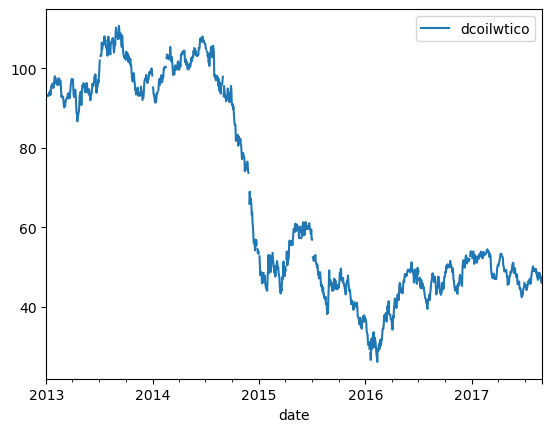

In [32]:
dataframes['oil'].plot()

#### We can see Oil Price significantly dropped in year 2015.
#### As we know that a magnitude 7.8 earthquake struck Ecuador on April 16, 2016, So we going to closely watch the Oil Price in year 2016

In [33]:
start_date = pd.to_datetime('2016-01-01')
end_date = pd.to_datetime('2016-12-31')

<Axes: xlabel='date'>

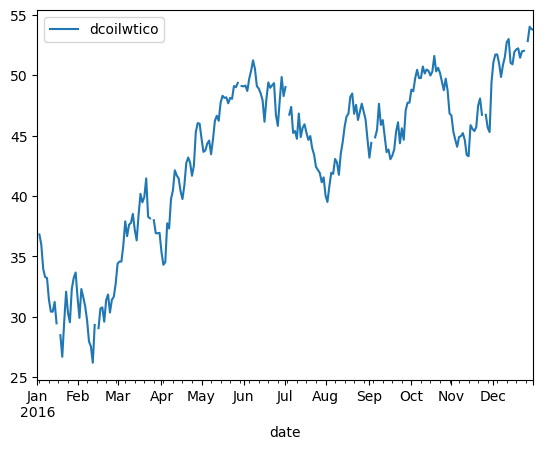

In [34]:
dataframes['oil'][start_date:end_date].plot()

In [35]:
#### Let's observe April 2016 Closely
start_date = pd.to_datetime('2016-04-01')
end_date = pd.to_datetime('2016-04-30')

<Axes: xlabel='date'>

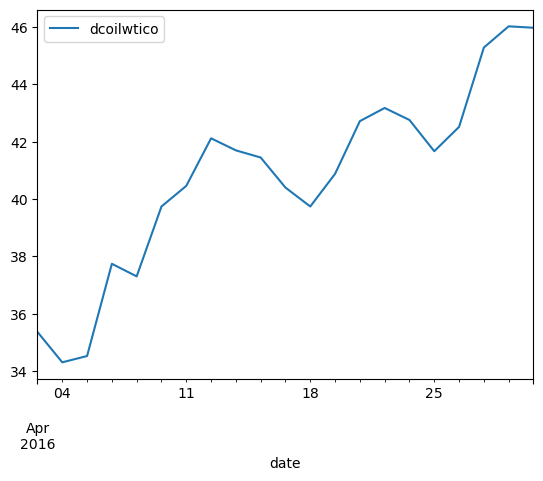

In [36]:
dataframes['oil'][start_date:end_date].plot()

In [37]:
dataframes['oil'].columns

Index(['dcoilwtico'], dtype='object')

In [38]:
dataframes['oil'].rename(columns={'dcoilwtico':'oil_price'},inplace=True)

In [39]:
#Plot month vs year graph
dataframes['oil']['month'] = dataframes['oil'].index.month
dataframes['oil']['year'] = dataframes['oil'].index.year

In [40]:
month_vs_year_sales_df = pd.pivot_table(dataframes['oil'],
                                        values='oil_price',
                                       columns='year',
                                       index='month',
                                       aggfunc='sum')

In [41]:
month_vs_year_sales_df

year,2013,2014,2015,2016,2017
month,,,,,
1,1989.89,1986.96,944.38,601.98,1050.08
2,1810.87,1915.53,961.10,606.46,1015.90
3,1858.77,2116.88,1052.12,826.02,1134.54
4,2024.47,2143.45,1143.51,855.86,970.15
5,2079.21,2145.72,1185.30,980.96,1066.48
6,1915.45,2221.68,1316.03,1072.66,993.91
7,2302.76,2278.95,1119.82,893.03,885.98
8,2344.60,2027.26,900.22,1028.66,1104.85
9,2125.79,1957.45,955.07,948.83,NaN


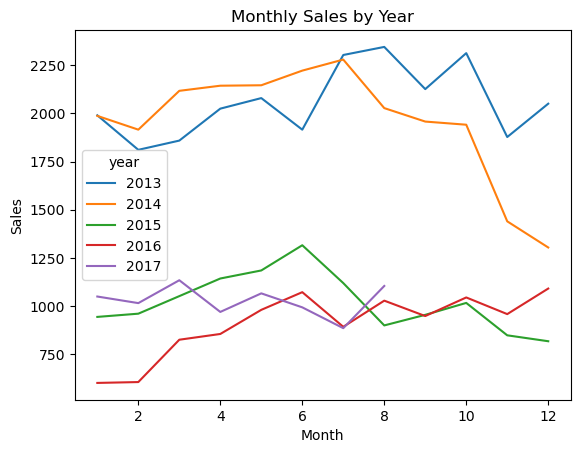

In [42]:
# Plot the pivot table DataFrame
month_vs_year_sales_df.plot()

# Set labels and title
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Monthly Sales by Year')

# Show the plot
plt.show()

In [43]:
#Mean of sales each year
dataframes['oil'].groupby('year')['oil_price'].mean()

year
2013    97.982540
2014    93.172222
2015    48.656706
2016    43.293651
2017    49.232874
Name: oil_price, dtype: float64

<p><b>Oil prices were lowest in 2016<b>

## Train Dataset Analysis

In [44]:
dataframes['train'].sample(5)

,id,date,store_nbr,family,sales,onpromotion
557709,557709,2013-11-09,8,DELI,367.816000,0
2158409,2158409,2016-04-29,20,FROZEN FOODS,58.850998,0
2828286,2828286,2017-05-11,16,LINGERIE,3.000000,0
1156472,1156472,2014-10-12,8,LAWN AND GARDEN,19.000000,0
504679,504679,2013-10-11,2,EGGS,175.000000,0


In [45]:
dataframes['train']['year'] = dataframes['train']['date'].dt.year
dataframes['train']['month'] = dataframes['train']['date'].dt.month

#### Mean Sales of each product family

In [46]:
dataframes['train'].groupby('family')['sales'].mean().sort_values(ascending=False)

family
GROCERY I                     3776.972100
BEVERAGES                     2385.793151
PRODUCE                       1349.352123
CLEANING                      1072.416744
DAIRY                          709.154889
BREAD/BAKERY                   463.336254
POULTRY                        350.532292
MEATS                          341.849965
PERSONAL CARE                  270.432513
DELI                           265.135067
HOME CARE                      176.198029
EGGS                           171.420516
FROZEN FOODS                   154.766954
PREPARED FOODS                  96.770202
LIQUOR,WINE,BEER                85.187824
SEAFOOD                         22.163190
GROCERY II                      21.584048
HOME AND KITCHEN I              20.470342
HOME AND KITCHEN II             16.722420
CELEBRATION                      8.370469
LINGERIE                         7.182128
LADIESWEAR                       7.160629
PLAYERS AND ELECTRONICS          6.186857
AUTOMOTIVE                 

#### Q. Which produc family was most used during year 2016 (earthquake)

In [47]:
dataframes['train'][ dataframes['train']['year'] == 2016 ].groupby('family')['sales'].mean()

family
AUTOMOTIVE                       6.855150
BABY CARE                        0.262100
BEAUTY                           5.047083
BEVERAGES                     3132.810096
BOOKS                            0.208980
BREAD/BAKERY                   520.173085
CELEBRATION                     14.143024
CLEANING                      1148.093709
DAIRY                          860.841857
DELI                           290.753667
EGGS                           184.552308
FROZEN FOODS                   178.986219
GROCERY I                     4367.657989
GROCERY II                      20.830036
HARDWARE                         1.216235
HOME AND KITCHEN I              29.225317
HOME AND KITCHEN II             26.436073
HOME APPLIANCES                  0.331456
HOME CARE                      285.671892
LADIESWEAR                      11.244089
LAWN AND GARDEN                  6.017199
LINGERIE                         5.566920
LIQUOR,WINE,BEER                96.037139
MAGAZINES                  

In [48]:
dataframes['train'].family.value_counts()

AUTOMOTIVE                    90936
HOME APPLIANCES               90936
SCHOOL AND OFFICE SUPPLIES    90936
PRODUCE                       90936
PREPARED FOODS                90936
POULTRY                       90936
PLAYERS AND ELECTRONICS       90936
PET SUPPLIES                  90936
PERSONAL CARE                 90936
MEATS                         90936
MAGAZINES                     90936
LIQUOR,WINE,BEER              90936
LINGERIE                      90936
LAWN AND GARDEN               90936
LADIESWEAR                    90936
HOME CARE                     90936
HOME AND KITCHEN II           90936
BABY CARE                     90936
HOME AND KITCHEN I            90936
HARDWARE                      90936
GROCERY II                    90936
GROCERY I                     90936
FROZEN FOODS                  90936
EGGS                          90936
DELI                          90936
DAIRY                         90936
CLEANING                      90936
CELEBRATION                 

#### Sum of Sales of each product family with/without promotion

In [50]:
dataframes['train'].groupby(['family','onpromotion'])['sales'].sum()

family      onpromotion
AUTOMOTIVE  0              514381.000000
            1               25722.000000
            2                6875.000000
            3                4188.000000
            4                1780.000000
                               ...      
SEAFOOD     3               31079.519019
            4               14628.439990
            5               24439.898078
            6               80369.470981
            7              104003.479042
Name: sales, Length: 1688, dtype: float64